### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [5]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


VERBOSE = 1
CV = [(slice(None), slice(None))]
TESTING = False

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [6]:
ITER = 2

hyperparameterspace = {
    'epochs': ["interval-int", 1, 50],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.01],
    'model__neurons_per_layer': ["interval-int", 1, 100],
    'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [7]:
ids = [233214]#, 233211]#, 359935, 359952, 359940, 359931]#, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(neurons_per_layer=20, number_of_layers=1): 
        # create model
        model = Sequential()
        model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
        for _ in range(number_of_layers):
            model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model


    def blackboxfunction(params):
        #index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        neurons_per_layer = int(params[3])

        number_of_layers = int(params[4])

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

        if TESTING:
            Y_predicted = model.predict(dataset.get_X_test())
            result = -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
            K.clear_session()
            return result 
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            result = -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
            K.clear_session()
            return result
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                for _ in range(number_of_layers):
                    model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
                model.add(Dense(1, activation=None))
                # Compile model
                
                optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
                K.clear_session()
                return result
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
                K.clear_session()
                return result
            


    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1)*len(hyperparameterspace.keys())
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by grid search:")
            print(result.best_params_)
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        K.clear_session()

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by random search:")
            print(result.best_params_)

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = i

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " + str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        TESTING = True
        BAYESIAN_RESULT.append(-blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(BUDGET)
        SPARSE_COST_OPTIMIZED.append(BUDGET)

        K.clear_session()
    


######################################################################################################################################################
Current Dataset: 1 of 1 with id: 233214

################################################## Current Budget: 5 ##################################################
Performing grid search
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best params found by grid search:
{'batch_size': 105, 'epochs': 25, 'model__neurons_per_layer': 50, 'model__number_of_layers': 5, 'optimizer__learning_rate': 3.16227766016838e-05}
Performing random search
Fitting 1 folds for each of 5 candidates, totalling 5 fits
Best params found by random search:
{'batch_size': 126, 'epochs': 24, 'model__neurons_per_layer': 70, 'model__number_of_layers': 6, 'optimizer__learning_rate': 5.345237958981696e-05}
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 65.66077027099527 seconds
With Hyperparameters: 
epochs: 33.04369744414515
batch_size: 152.4651325857551
optimizer__learning_rate: 0.00594834116371897
model__neurons_per_layer: 99.85542963368002
model__number_of_layers: 4.7099981968685345
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 280071ms.
Solving linear system (automatic method)...
Done in 2ms.

Optimal hyperparameters so far:
epochs: 13.25
batch_size: 57.5
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.7620785723571801
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.0000189858419195
batch_size: 10.000077245732953
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 1.0000051806620263
model__number_of_layers: 9.999996225799553
Resulting loss (Optimal value from optimization):
-3.014884187936054
Resulting loss (Optimal point evaluated

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 66.7226120699961 seconds
With Hyperparameters: 
epochs: 7.180643107950331
batch_size: 28.28718582959619
optimizer__learning_rate: 0.004261634663362343
model__neurons_per_layer: 81.42585469206918
model__number_of_layers: 9.088510395478025
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 344763ms.
Solving linear system (automatic method)...
Done in 4ms.

Optimal hyperparameters so far:
epochs: 25.5
batch_size: 152.5
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.7685511462343841
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 25.5
batch_size: 152.5
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss (Optimal value from optimization):
0.7685511462343841
Resulting loss (Optimal point evaluated):
0.824584219105982


[1.1758904, 1.2548244]
[1.1106437, 1.1687624]
[1.1295484, 1.0637109]
[1.0304982285599091, 0.9516423171818569]
[1.1111003661723793, 0.9611774065905159]
Current dataset: 0 with name id: 233214


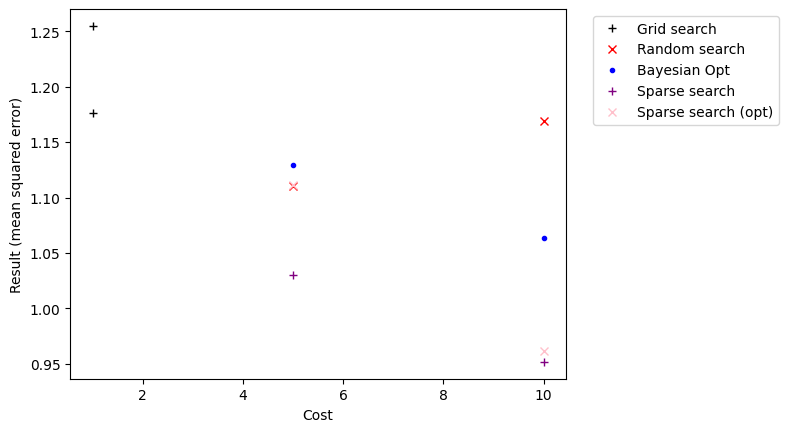

In [8]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        #plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

